In [2]:
import itertools
from bboxes_utils import bboxes_from_fast_rcnn, bboxes_training, bboxes_resize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import argparse
import functools
from tqdm.auto import tqdm

os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import numpy as np
import tensorflow as tf

from svhn_dataset import SVHN
from svhn_augmentations import DatasetFactory
from svhn_anchors import AnchorsFactory
from svhn_competition import RetinaNet, RetinaNetInference

In [14]:
def iterate_images(dataset, model=None):
    for x, y in dataset:
        y_pred = {} if model is None else model(x)
        
        for i in range(x.shape[0]):
            x_out = x[i, None]
            y_true_out = {k: v[i] for k, v in y.items()}
            y_pred_out = {k: v[i] for k, v in y_pred.items()}
            yield x_out, y_true_out, y_pred_out

In [15]:
def plot_img(x):
    x = np.squeeze(x)
    x = (x - np.min(x, axis=(0, 1))) / (np.max(x, axis=(0, 1)) - np.min(x, axis=(0, 1)))
    plt.imshow(x)
    
def plot_bboxes(bboxes, color):
    global BBOXES_POINTS
    if BBOXES_POINTS:
        y_c = (bboxes[..., 0] + bboxes[..., 2]) / 2.
        x_c = (bboxes[..., 1] + bboxes[..., 3]) / 2.
        plt.scatter(x_c, y_c, c=color)
    else:
        for bbox in bboxes:
            plt.gca().add_patch(patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], facecolor=(0,0,0,0), edgecolor=color))

In [16]:
svhn = SVHN()
anchors_factory = AnchorsFactory(levels=(3, 7))#, scales=[0.5, 1.], ratios=[0.5, 1, ])
dataset_factory = DatasetFactory(match_scales_dim=122, svhn=svhn, batch_size=256, anchors_factory=anchors_factory, iou_threshold=0.5, bg_iou_threshold=0.4, shuffle_train=False)

dataset = dataset_factory.build('test')

In [17]:
model = RetinaNet(num_classes=SVHN.LABELS, backbone='resnet', levels=(3, 7), n_anchors=anchors_factory.anchors_per_unit)
model.load_weights('./weights')

In [18]:
imodel = RetinaNetInference(model, anchors_factory, max_output_size_per_class=10, max_total_size=10, iou_threshold=0.2, any_iou_threshold=0.4, score_threshold=0.4)

In [19]:
it = iter(iterate_images(dataset, imodel))

In [20]:
BBOXES_POINTS = False

  true: []
  pred: [3]
scores: [0.47708437]


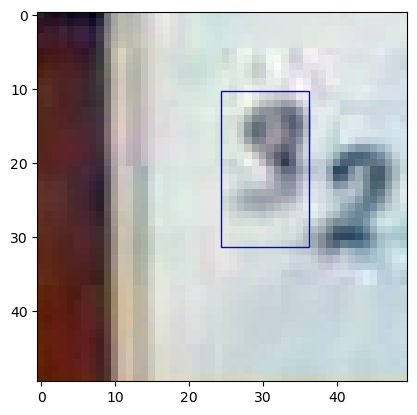

In [82]:
x, y_true, y_pred = next(it)
h, w = int(x.shape[-3]), int(x.shape[-2])
orig_h, orig_w = DatasetFactory.decode_dimensions_from_images(x)
x = tf.image.resize(x, (int(orig_h), int(orig_w)))

x = x.numpy()
y_true_bbox, y_true_cls = y_true['bboxes'], y_true['classes'].numpy()

anchors = anchors_factory.build(height=h, width=w)
y_true_bbox = bboxes_from_fast_rcnn(anchors, y_true_bbox)
y_true_bbox = bboxes_resize(y_true_bbox, tf.cast(orig_h / h, tf.float32), tf.cast(orig_w / w, tf.float32), orig_h, orig_w)
y_true_bbox = y_true_bbox.numpy()

plot_img(x)
# if not y_pred:
    # plot_bboxes(y_true_bbox[y_true_cls == 1], 'g')
plot_bboxes(y_true_bbox[y_true_cls >= 2], 'r')

if not y_pred:
    plot_bboxes(anchors[y_true_cls >= 2], 'b')
    print(y_true_cls[y_true_cls >= 2] - 2)

if y_pred:
    y_pred_bbox, y_pred_cls = y_pred['bboxes'].numpy(), y_pred['classes'].numpy()
    plot_bboxes(y_pred_bbox, 'b')
    print("  true:", y_true_cls[y_true_cls >= 2] - 2)
    print("  pred:", y_pred_cls.astype(int))
    print("scores:", y_pred['scores'].numpy())

plt.show()